# ST446 Distributed Computing for Big Data

## Seminar class 3: getting started with PySpark

In this exercise, we are going to create and perform various transformations of resilient distributed datasets (RDD) in PySpark.

**Note: Make sure you open jupyter using command `pyspark` not `jupyter notebook`! 
You can switch between Python and PySpark via the menu item "Kernel/Change Kernel".**

## 1. Creating RDDs

There are two ways to create an RDD in PySpark:

### a) parallelize a list

In [4]:
data = sc.parallelize([('a', 1), ('b', 4), ('c',10)])
data.collect()

[('a', 1), ('b', 4), ('c', 10)]

or

### b) read from a data source (a file or a database)

We can use `textFile` function to fetch the files in our bucket.
First copy `author-large.txt` in the gcp master host to the bucket, then run the following command

In [19]:
# edit location
data_from_file = sc.\
    textFile(
        "gs://jialin-bucket/author-large.txt", 
        4)

You should change the path to where the file is.

When you read from a text file, each row from the file forms an element of the RDD.

But what does `sc` mean? It's the Spark context. SparkContext (aka Spark context) is the heart of a Spark application. It's the thing that connects you to the spark execution environment, i.e., it coordinates what's going on behind the scenes.

In [20]:
data_from_file.take(5)

[u'Jurgen Annevelink\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 u'Rafiul Ahad\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 u'Amelia Carlson\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 u'Daniel H. Fishman\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995',
 u'Michael L. Heytens\tModern Database Systems\tObject SQL - A Language for the Design and Implementation of Object Databases.\t1995']

Looks familiar?

### Schema

RDD is a *schema-less* data structure.

In [21]:
data_heterogenous = sc.parallelize([('Ferrari', 'fast'), {'Porsche': 100000}, ['Spain','visited', 4504]]).collect()
data_heterogenous

[('Ferrari', 'fast'), {'Porsche': 100000}, ['Spain', 'visited', 4504]]

You can access the object that stored in an RDD element as you would normally do in Python.

In [22]:
data_heterogenous[1]['Porsche']

100000

## 2. Transformations

### a) .map(...)

.map applies (...) to each element of the RDD. Here we transform each row of the `data_from_file` from a string to a list of strings.

In [23]:
def extractInformation(row):
    import re
    import numpy as np
    
    row = row.strip() # remove leading and trailing whitespaces
    words = np.array(row.split("\t")) # split the line into words by tab
    return words

data_from_file_conv = data_from_file.map(extractInformation)
data_from_file_conv.map(lambda row: row).take(5)

[array([u'Jurgen Annevelink', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Rafiul Ahad', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Amelia Carlson', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Daniel H. Fishman', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Michael L. Heytens', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78')]

Or we can use a lambda expression to split and transform our dataset. You should get the same result as above.

In [10]:
import numpy as np
data_from_file_conv = data_from_file.map(lambda row: np.array(row.strip().split("\t")))
data_from_file_conv.take(5)

[array([u'Jurgen Annevelink', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Rafiul Ahad', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Amelia Carlson', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Daniel H. Fishman', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78'),
 array([u'Michael L. Heytens', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78')]

We can filter and transform only one part of an RDD element: 

In [11]:
publish_year = data_from_file_conv.map(lambda row: int(row[3]))
publish_year.take(10)

[1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995]

or, we can combine multiple part of an RDD element:

In [12]:
author_book = data_from_file_conv.map(lambda row: (row[0], row[2]))
author_book.take(5)

[(u'Jurgen Annevelink',
  u'Object SQL - A Language for the Design and Implementation of Object Databases.'),
 (u'Rafiul Ahad',
  u'Object SQL - A Language for the Design and Implementation of Object Databases.'),
 (u'Amelia Carlson',
  u'Object SQL - A Language for the Design and Implementation of Object Databases.'),
 (u'Daniel H. Fishman',
  u'Object SQL - A Language for the Design and Implementation of Object Databases.'),
 (u'Michael L. Heytens',
  u'Object SQL - A Language for the Design and Implementation of Object Databases.')]

### .flatMap(...)

The `.flatMap(...)` method works similarly to `.map(...)` but returns a flattened result instead of a list. 

In [16]:
publish_year_2_flat = data_from_file_conv.flatMap(lambda row: (row[0], row[2]))
publish_year_2_flat.take(10)

[u'Jurgen Annevelink',
 u'Object SQL - A Language for the Design and Implementation of Object Databases.',
 u'Rafiul Ahad',
 u'Object SQL - A Language for the Design and Implementation of Object Databases.',
 u'Amelia Carlson',
 u'Object SQL - A Language for the Design and Implementation of Object Databases.',
 u'Daniel H. Fishman',
 u'Object SQL - A Language for the Design and Implementation of Object Databases.',
 u'Michael L. Heytens',
 u'Object SQL - A Language for the Design and Implementation of Object Databases.']

### b) .filter(...)

The `.filter(...)` method allows us to select elements of an RDD that statisfy specified criteria. Here we filter all the elements with author name 'Hans-Peter Seidel'.

In [17]:
data_filtered = data_from_file_conv.filter(lambda row: row[0] == 'Hans-Peter Seidel') 
data_filtered.take(5)

[array([u'Hans-Peter Seidel', u'3DIM',
        u'Accuracy of 3D Range Scanners by Measurement of the Slanted Edge Modulation Transfer Function.',
        u'2003'], dtype='<U94'), array([u'Hans-Peter Seidel', u'3DPVT',
        u'A Statistical Method for Robust 3D Surface Reconstruction from Sparse Data.',
        u'2004'], dtype='<U75'), array([u'Hans-Peter Seidel', u'3DPVT', u'Neural Mesh Ensembles.', u'2004'],
       dtype='<U22'), array([u'Hans-Peter Seidel',
        u'IEEE Workshop on Multimedia Signal Processing',
        u'Combining stereo and visual hull information for on-line reconstruction and rendering of dynamic scenes.',
        u'2002'], dtype='<U104'), array([u'Hans-Peter Seidel', u'AMDO',
        u'Modeling Relaxed Hand Shape for Character Animation.', u'2006'],
       dtype='<U52')]

### c) .distinct()

This method returns a list of distinct values of transformed RDD elements.

In [18]:
distinct_author = data_from_file_conv.map(lambda row: row[0]).distinct()
distinct_author.count()

581765

### d) .sample(...)

The `.sample()` method returns a random subset of an RDD.

In [19]:
fraction = 0.1
data_sample = data_from_file_conv.sample(False, fraction, 666)

data_sample.take(1)

[array([u'Daniel H. Fishman', u'Modern Database Systems',
        u'Object SQL - A Language for the Design and Implementation of Object Databases.',
        u'1995'], dtype='<U78')]

Let's confirm that we really got 10% of all the elements.

In [22]:
length_original = data_from_file_conv.count()
length_sample = data_sample.count()
print('Original dataset: ', length_original) 
print('Sample', length_sample)
print('Ratio', length_sample*1.0/length_original)

('Original dataset: ', 2225370)
('Sample', 222417)
('Ratio', 0.09994607638280376)


### e) Join

Here we demonstrate the join operation for two pair RDDs:

In [10]:
rdd1 = sc.parallelize([('a', 1), ('b', 4), ('c',10)])
rdd2 = sc.parallelize([('a', 1), ('b', 6), ('d', 15),('d', 3),('e', 2),('a', 8),('d', 2),('e', 1),('f', 3)])

#### .leftOuterJoin(...)

Left outer join, just like in SQL, joins two pair RDDs (left and right) based on their keys. For each key of the left RDD, it returns the corresponding value of the left RDD and the value of the right RDD if there there is a matching key (otherwise a null value).

In [26]:
rdd1.leftOuterJoin(rdd2).collect()

[('a', (1, 1)), ('a', (1, 8)), ('c', (10, None)), ('b', (4, 6))]

#### .join(...)

If we used `.join(...)` method instead we would have gotten only the values for `'a'` and `'b'` as these two values intersect between these two RDDs.

In [24]:
rdd1.join(rdd2).collect()

[('a', (1, 1)), ('a', (1, 8)), ('b', (4, 6))]

#### .intersection(...)

Another useful method is the `.intersection(...)` that returns elements that are in both RDDs.

In [27]:
rdd1.intersection(rdd2).collect()

[('a', 1)]

### f) .repartition(...)

Repartitioning a dataset changes the number of partitions the dataset is divided into.

In [29]:
print('before repartition:', len(rdd1.glom().collect()))
rdd1 = rdd1.repartition(4)

print('after repartition:', len(rdd1.glom().collect()))

('before repartition:', 2)
('after repartition:', 4)


## 3. Actions

### a) .take(...)

The method returns specified number of top elements from a single dataset partition.

In [30]:
data_first = rdd1.take(1)
data_first

[('b', 4)]

####  .takeSample(...)
If we want to get a pseudo random subset of elements, we can use `.takeSample(...)` instead.

In [31]:
data_take_sampled = rdd1.takeSample(False, 1, 667)
data_take_sampled

[('c', 10)]

### b) .reduce(...)

The method `.reduce(...)` *reduces* the elements of an RDD using a specified function.

In [5]:
data_reduce_1 = sc.parallelize([1, 2., .5, .3, 5, .2], 1)
print(data_reduce_1.reduce(lambda x, y: x + y))

9.0


Even if we partition the dataset in a different way, we still get the same result because the given reduce function is associative and commutative.

In [6]:
data_reduce_2 = sc.parallelize([1, 2., .5, .3, 5, .2], 3)
print(data_reduce_2.reduce(lambda x, y: x + y))

9.0


If the reduce function is not associative and commutative, you may get a wrong result depending on how your data is partitioned.

For example, if we were to reduce the data by *dividing* the current result with the input element, we should obtain 3.33... as the result.

In [7]:
print(data_reduce_1.reduce(lambda x, y: x / y))

3.33333333333


However, if the dataset is partitioned into 3 partitions, the result will be incorrect. Why?

In [8]:
print(data_reduce_2.reduce(lambda x, y: x / y))

0.012


#### .reduceByKey(...)

The `.reduceByKey(...)` method works in a similar way to the `.reduce(...)` method but performs a reduction per distinct key.

In [11]:
rdd2.reduceByKey(lambda x, y: x + y).collect()

[('a', 9), ('e', 3), ('b', 6), ('d', 20), ('f', 3)]

### c) .count()

The `.count()` method counts the number of elements in the RDD.

In [12]:
rdd2.count()

9

It has the same effect as the method below but does not require shifting the data to the driver node.

In [13]:
len(rdd2.collect()) # DON'T DO THIS - it is expensive!

9

If your dataset is in the form of *key-value* you can use the `.countByKey()` method to get the counts for distinct keys.

In [14]:
rdd2.countByKey().items()

[('a', 2), ('b', 1), ('e', 2), ('d', 3), ('f', 1)]

### d) .saveAsTextFile(...)

As the name suggests, the `.saveAsTextFile()` saves the RDD to text files: each partition to a separate file.

In [15]:
my_filename = 'gs://jialin-bucket/rdd3'
rdd2.saveAsTextFile(my_filename)

To read the file, you need to parse as all elements are interpreted as strings.

In [16]:
def parseInput(row):
    import re
    
    pattern = re.compile(r'\(\'([a-z])\', ([0-9]+)\)')
    row_split = pattern.split(row)
    return (row_split[1], int(row_split[2]))
    
data_key_reread = sc \
    .textFile(my_filename) \
    .map(parseInput)
data_key_reread.collect()

[(u'a', 1),
 (u'b', 6),
 (u'd', 15),
 (u'd', 3),
 (u'e', 2),
 (u'a', 8),
 (u'd', 2),
 (u'e', 1),
 (u'f', 3)]

### e) .foreach(...)

The method `.foreach(...)` applies the same function to each element of the RDD in an iterative way. The difference from map is it returns nothing.

In [17]:
def f(x): 
    print(x)

data_reduce_1.foreach(f) # you won't see the output here as `print(...)` is applied to each RDD element

# Let's see how partitions change the speed

In [37]:
size = 1000
bigrdd = data_from_file_conv.map(lambda row: row[0])

In [38]:
import time
from numpy import sqrt, array, sin
times = []

for npart in range(25,0,-1):
    bigrdd = bigrdd.repartition(npart)
    print("Number of partitions: {}".format(bigrdd.getNumPartitions()))
    t0 = time.time()
    a0 = bigrdd.takeSample(True, size, 123);
    dt = time.time() - t0;
    print("time: ",dt)
    times = times + [dt]

Number of partitions: 25
('time: ', 29.64565110206604)
Number of partitions: 24
('time: ', 7.6920459270477295)
Number of partitions: 23
('time: ', 7.327723026275635)
Number of partitions: 22
('time: ', 6.548742055892944)
Number of partitions: 21
('time: ', 6.574919939041138)
Number of partitions: 20
('time: ', 6.419106960296631)
Number of partitions: 19
('time: ', 6.5730390548706055)
Number of partitions: 18
('time: ', 6.555976152420044)
Number of partitions: 17
('time: ', 6.653263807296753)
Number of partitions: 16
('time: ', 6.516002893447876)
Number of partitions: 15
('time: ', 6.342061996459961)
Number of partitions: 14
('time: ', 6.277467966079712)
Number of partitions: 13
('time: ', 6.6794350147247314)
Number of partitions: 12
('time: ', 6.260401010513306)
Number of partitions: 11
('time: ', 6.317389011383057)
Number of partitions: 10
('time: ', 6.282149076461792)
Number of partitions: 9
('time: ', 6.6583051681518555)
Number of partitions: 8
('time: ', 6.543514966964722)
Number o

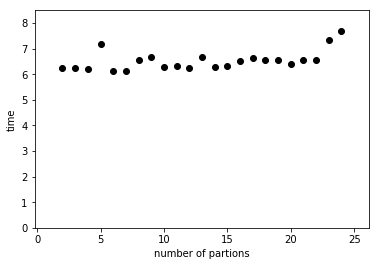

In [39]:
times = array(times)
from matplotlib import pyplot as plt
plt.plot(range(25,0,-1),times,'ko')
plt.xlabel("number of partions")
plt.ylabel("time")
plt.ylim([0,8.5])
plt.show();

There's some interesting structure here. Too few or too many partitions generally slow down the code.